# GPU-IFIED CODE
### Can run with or without CUDA

In [1]:
import sys
print(sys.executable)

/home/rteam8/anaconda3/envs/tuninggpu310/bin/python3.10


In [2]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
import gc
import random
from IPython.display import clear_output

In [4]:
import json

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [7]:
# Settings
N_FOLDS = 10
N_REPEATS = 3
# BATCHSIZE = 128  # Not used in Random Forest
CLASSES = 13

# INPUT_SIZE = 83  # Not used in Random Forest, but retained for consistency

FIG_SIZE = (12, 12)
num_iters = "_100"
model_type = "_xgb"
CHECKPOINT_DIR = f"./checkpoints{model_type}{num_iters}"

In [8]:
# NUM_BOOST_ROUNDS = 1_500
# EARLY_STOPPING_ROUNDS = 300
# SAVE_MODEL_EVERY = 300
# VERBOSE_EVAL = 5

In [9]:
# Hyperparameters for XGBoost (from Optuna) without GPU configurations
BEST_XGB_PARAMS = {
    'num_boost_round': 100,
    'device': 'cuda',
    'alpha': 0.6752478197096309,
    'booster': "gbtree",
    'colsample_bytree': 0.6992926309118707,
    'lambda': 0.000016278902198891244,
    'subsample': 0.9267281985537734,
    'learning_rate': 0.19135741143814938,  # eta
    'gamma': 0.011591838343446076,
    'max_depth': 34,
    'min_child_weight': 5,
    'grow_policy': "depthwise",
    'objective': "multi:softprob",
    'num_class': CLASSES,  
    'random_state': SEED,                # Ensure reproducibility
    'n_jobs': -1,                         # Utilize all available cores
    'verbosity': 0,
    # Removed 'tree_method' and 'gpu_id' as GPU is not available
    # Removed 'grow_policy' as it's optional and not necessary here
    'disable_default_eval_metric': 1, 
    # 'normalize_type': 'tree',
    # 'rate_drop': 1.5562623352315277e-7,
    # 'sample_type': 'uniform',
    # 'skip_drop': 0.06838834680508599,
    'seed': SEED,
}

In [10]:
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [11]:
# Create necessary folders
def create_folders():
    folders = [
        f"outputs{model_type}{num_iters}/overall",
        f"outputs{model_type}{num_iters}/validation_model",
        f"outputs{model_type}{num_iters}/evaluation_model_full_training_set",
    ]
    
    for folder in folders:
        os.makedirs(folder, exist_ok=True)

In [12]:
create_folders()

In [13]:
save_path = f"outputs{model_type}{num_iters}/overall/"

In [14]:
# # Custom macro F1 score for XGBoost
# def macro_f1_score_xgb(preds, dtrain):
#     y_true = dtrain.get_label()
#     y_pred = np.argmax(preds, axis=1)
#     f1 = f1_score(y_true, y_pred, average='macro')
#     return 'macro_f1', f1

In [15]:
# Cell 2: Load and Preprocess Data

def load_and_preprocess_data(filepath):
    """
    Loads data from a CSV file, replaces placeholders, and separates features from target.
    
    Args:
        filepath (str): Path to the CSV file.
        
    Returns:
        data (pd.DataFrame): Feature dataframe.
        target (pd.Series): Target labels.
        feature_names (list): List of feature names.
    """
    data = pd.read_csv(filepath)
    
    # Replace '-' with 'None' in categorical columns
    data['service'] = data['service'].replace('-', 'None')
    data['proto'] = data['proto'].replace('-', 'None')
    
    # Separate features and target
    feature_names = data.drop(columns=['Attack_type']).columns.tolist()
    target = data['Attack_type']
    data = data.drop(columns=['Attack_type'])
    
    return data, target, feature_names

In [16]:
# Load the dataset
data, target, feature_names = load_and_preprocess_data('./RT_IOT2022_new.csv')

In [17]:
def encode_targets(target):
    """
    Encodes categorical target labels into numerical codes.
    
    Args:
        target (pd.Series): Categorical target labels.
        
    Returns:
        target_encoded (np.ndarray): Encoded target labels.
        class_labels (list): List of class names.
        target_encoder (LabelEncoder): Fitted LabelEncoder instance.
    """
    target_encoder = LabelEncoder()
    target_encoded = target_encoder.fit_transform(target)
    class_labels = target_encoder.classes_
    return target_encoded, class_labels, target_encoder

In [18]:
# Encode target labels
Y_encoded, class_labels, target_encoder = encode_targets(target)

In [19]:
print(f"Number of unique classes: {len(class_labels)}")
print(f"Class labels: {class_labels}")

Number of unique classes: 13
Class labels: ['ARP_poisioning' 'Alexa' 'DDOS_Slowloris' 'DOS_SYN_Hping' 'MQTT_Publish'
 'Metasploit_Brute_Force_SSH' 'NMAP_FIN_SCAN' 'NMAP_OS_DETECTION'
 'NMAP_TCP_scan' 'NMAP_UDP_SCAN' 'NMAP_XMAS_TREE_SCAN' 'Thing_Speak'
 'Wipro_bulb']


In [20]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    data, Y_encoded, test_size=0.2, random_state=SEED, stratify=Y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Clean up to save memory
del data
del target

Training set size: (167967, 83)
Test set size: (41992, 83)


In [21]:
# Cell 5: Define Preprocessing and Model Pipeline

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=["int64", "float64", "float32"]).columns.tolist()
categorical_cols = ["proto", "service"]  # Adjust based on your data

# Update preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define XGBoost without GPU
xgb_classifier = XGBClassifier(
    **BEST_XGB_PARAMS,
    enable_categorical=False  # Use preprocessed categorical data
)

# Create the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])


In [22]:
from sklearn.metrics import make_scorer

In [23]:
# # Sample a small subset for testing
# X_sample = X_train.iloc[:100]
# Y_sample = Y_train[:100]

# # Perform stratified sampling to ensure all classes are represented
# X_sample, _, Y_sample, _ = train_test_split(
#     X_train, Y_train, test_size=0.9, random_state=SEED, stratify=Y_train
# )

# print(f"Sampled X_sample shape: {X_sample.shape}")
# print(f"Sampled Y_sample shape: {Y_sample.shape}")
# print(f"Unique classes in Y_sample: {np.unique(Y_sample)}")

# # Fit the pipeline
# model_pipeline.fit(X_sample, Y_sample)

# # Predict using the pipeline
# Y_pred_sample = model_pipeline.predict(X_sample)
# Y_pred_proba_sample = model_pipeline.predict_proba(X_sample)

# print("Sample Predictions:", Y_pred_sample)
# print("Sample Probabilities:", Y_pred_proba_sample)

In [24]:
from sklearn.metrics import make_scorer

In [25]:
# Cell 6: Run Cross-Validation and Save the Best Model

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Initialize cross-validation
rskf = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=SEED)

# Variables to track the best model
best_macro_f1 = -float('inf')
best_model_path = os.path.join(CHECKPOINT_DIR, f"best_xgb_model{num_iters}.joblib")

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(rskf.split(X_train, Y_train), 1): # enumerate starts from 1
    print(f"\nFold {fold}/{N_FOLDS * N_REPEATS}")
    
    # Split the data
    X_train_fold = X_train.iloc[train_idx].copy()
    Y_train_fold = Y_train[train_idx].copy()
    X_valid_fold = X_train.iloc[val_idx].copy()
    Y_valid_fold = Y_train[val_idx].copy()
    
    # Print shapes before preprocessing
    print(f"Before preprocessing: X_train_fold shape: {X_train_fold.shape}, X_valid_fold shape: {X_valid_fold.shape}")
    
    # Fit the pipeline on the training fold
    model_pipeline.fit(X_train_fold, Y_train_fold)
    
    # Access the preprocessor from the pipeline
    preprocessor = model_pipeline.named_steps['preprocessor']
    
    # Transform the data to get the shapes after preprocessing
    X_train_transformed = preprocessor.transform(X_train_fold)
    X_valid_transformed = preprocessor.transform(X_valid_fold)
    
    # Print shapes after preprocessing
    print(f"After preprocessing: X_train_fold shape: {X_train_transformed.shape}, X_valid_fold shape: {X_valid_transformed.shape}")
    
    # Predict on training and validation folds
    Y_train_pred = model_pipeline.predict(X_train_fold)
    Y_train_pred_proba = model_pipeline.predict_proba(X_train_fold)
    
    Y_valid_pred = model_pipeline.predict(X_valid_fold)
    Y_valid_pred_proba = model_pipeline.predict_proba(X_valid_fold)
    
    # Compute training metrics
    train_bal_acc = balanced_accuracy_score(Y_train_fold, Y_train_pred)
    train_accuracy = accuracy_score(Y_train_fold, Y_train_pred)
    train_macro_f1 = f1_score(Y_train_fold, Y_train_pred, average='macro')
    train_precision = precision_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
    train_recall = recall_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
    train_auc = roc_auc_score(
        label_binarize(Y_train_fold, classes=np.arange(CLASSES)),
        Y_train_pred_proba,
        average='macro',
        multi_class='ovo'
    )
    
    # Compute validation metrics
    val_bal_acc = balanced_accuracy_score(Y_valid_fold, Y_valid_pred)
    val_accuracy = accuracy_score(Y_valid_fold, Y_valid_pred)
    val_macro_f1 = f1_score(Y_valid_fold, Y_valid_pred, average='macro')
    val_precision = precision_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
    val_recall = recall_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
    val_auc = roc_auc_score(
        label_binarize(Y_valid_fold, classes=np.arange(CLASSES)),
        Y_valid_pred_proba,
        average='macro',
        multi_class='ovo'
    )
    
    print(f"Training Balanced Accuracy: {train_bal_acc:.4f}")
    print(f"Validation Balanced Accuracy: {val_bal_acc:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Macro F1 Score: {train_macro_f1:.4f}")
    print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
    print(f"Training Precision (Macro): {train_precision:.4f}")
    print(f"Validation Precision (Macro): {val_precision:.4f}")
    print(f"Training Recall (Macro): {train_recall:.4f}")
    print(f"Validation Recall (Macro): {val_recall:.4f}")
    print(f"Training ROC AUC Score: {train_auc:.4f}")
    print(f"Validation ROC AUC Score: {val_auc:.4f}")
    
    # Save metrics for this fold, including predictions
    metrics = {
        "train_balanced_accuracy": train_bal_acc,
        "train_accuracy": train_accuracy,
        "train_macro_f1": train_macro_f1,
        "train_precision_macro": train_precision,
        "train_recall_macro": train_recall,
        "train_auc": train_auc,
        "validation_balanced_accuracy": val_bal_acc,
        "validation_accuracy": val_accuracy,
        "validation_macro_f1": val_macro_f1,
        "validation_precision_macro": val_precision,
        "validation_recall_macro": val_recall,
        "validation_auc": val_auc,
        "val_y_true": Y_valid_fold.tolist(),
        "val_y_pred": Y_valid_pred.tolist(),
        "val_y_score": Y_valid_pred_proba.tolist()
    }
    metrics_file = os.path.join(CHECKPOINT_DIR, f"metrics_fold{fold}{num_iters}.json")
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"Metrics saved to {metrics_file}")
    
    # Check if this fold's model is the best so far
    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        # Save the model
        joblib.dump(model_pipeline, best_model_path)
        print(f"Best model updated and saved to {best_model_path} with Macro F1: {best_macro_f1:.4f}")
    
    # Optional: Save the model for each fold
    model_path = os.path.join(CHECKPOINT_DIR, f"model_fold{fold}{num_iters}.joblib")
    joblib.dump(model_pipeline, model_path)
    print(f"Model for fold {fold} saved to {model_path}")
    
    # Clean up
    del X_train_fold, Y_train_fold, X_valid_fold, Y_valid_fold, Y_train_pred, Y_train_pred_proba, Y_valid_pred, Y_valid_pred_proba
    gc.collect()
    
print("Cross-validation completed successfully.")


Fold 1/30


Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9777
Validation Balanced Accuracy: 0.9644
Training Accuracy: 0.9997
Validation Accuracy: 0.9992
Training Macro F1 Score: 0.9864
Validation Macro F1 Score: 0.9685
Training Precision (Macro): 0.9962
Validation Precision (Macro): 0.9729
Training Recall (Macro): 0.9777
Validation Recall (Macro): 0.9644
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold1_100.json
Best model updated and saved to ./checkpoints_xgb_100/best_xgb_model_100.joblib with Macro F1: 0.9685
Model for fold 1 saved to ./checkpoints_xgb_100/model_fold1_100.joblib

Fold 2/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9683
Validation Balanced Accuracy: 0.9929
Training Accuracy: 0.9997
Validation Accuracy: 0.9990
Training Macro F1 Score: 0.9821
Validation Macro F1 Score: 0.9952
Training Precision (Macro): 0.9990
Validation Precision (Macro): 0.9975
Training Recall (Macro): 0.9683
Validation Recall (Macro): 0.9929
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold2_100.json
Best model updated and saved to ./checkpoints_xgb_100/best_xgb_model_100.joblib with Macro F1: 0.9952
Model for fold 2 saved to ./checkpoints_xgb_100/model_fold2_100.joblib

Fold 3/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9692
Validation Balanced Accuracy: 0.9668
Training Accuracy: 0.9997
Validation Accuracy: 0.9989
Training Macro F1 Score: 0.9825
Validation Macro F1 Score: 0.9796
Training Precision (Macro): 0.9989
Validation Precision (Macro): 0.9978
Training Recall (Macro): 0.9692
Validation Recall (Macro): 0.9668
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold3_100.json
Model for fold 3 saved to ./checkpoints_xgb_100/model_fold3_100.joblib

Fold 4/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 93), X_valid_fold shape: (16797, 93)


Training Balanced Accuracy: 0.9776
Validation Balanced Accuracy: 0.8974
Training Accuracy: 0.9997
Validation Accuracy: 0.9985
Training Macro F1 Score: 0.9876
Validation Macro F1 Score: 0.9277
Training Precision (Macro): 0.9990
Validation Precision (Macro): 0.9968
Training Recall (Macro): 0.9776
Validation Recall (Macro): 0.8974
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold4_100.json
Model for fold 4 saved to ./checkpoints_xgb_100/model_fold4_100.joblib

Fold 5/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9685
Validation Balanced Accuracy: 0.9429
Training Accuracy: 0.9997
Validation Accuracy: 0.9985
Training Macro F1 Score: 0.9822
Validation Macro F1 Score: 0.9570
Training Precision (Macro): 0.9991
Validation Precision (Macro): 0.9966
Training Recall (Macro): 0.9685
Validation Recall (Macro): 0.9429
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold5_100.json
Model for fold 5 saved to ./checkpoints_xgb_100/model_fold5_100.joblib

Fold 6/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9781
Validation Balanced Accuracy: 0.9123
Training Accuracy: 0.9997
Validation Accuracy: 0.9985
Training Macro F1 Score: 0.9878
Validation Macro F1 Score: 0.9390
Training Precision (Macro): 0.9989
Validation Precision (Macro): 0.9968
Training Recall (Macro): 0.9781
Validation Recall (Macro): 0.9123
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold6_100.json
Model for fold 6 saved to ./checkpoints_xgb_100/model_fold6_100.joblib

Fold 7/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9707
Validation Balanced Accuracy: 0.9682
Training Accuracy: 0.9997
Validation Accuracy: 0.9988
Training Macro F1 Score: 0.9823
Validation Macro F1 Score: 0.9699
Training Precision (Macro): 0.9958
Validation Precision (Macro): 0.9717
Training Recall (Macro): 0.9707
Validation Recall (Macro): 0.9682
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold7_100.json
Model for fold 7 saved to ./checkpoints_xgb_100/model_fold7_100.joblib

Fold 8/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9686
Validation Balanced Accuracy: 0.9976
Training Accuracy: 0.9996
Validation Accuracy: 0.9990
Training Macro F1 Score: 0.9809
Validation Macro F1 Score: 0.9871
Training Precision (Macro): 0.9955
Validation Precision (Macro): 0.9793
Training Recall (Macro): 0.9686
Validation Recall (Macro): 0.9976
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold8_100.json
Model for fold 8 saved to ./checkpoints_xgb_100/model_fold8_100.joblib

Fold 9/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9694
Validation Balanced Accuracy: 0.9595
Training Accuracy: 0.9997
Validation Accuracy: 0.9985
Training Macro F1 Score: 0.9827
Validation Macro F1 Score: 0.9425
Training Precision (Macro): 0.9991
Validation Precision (Macro): 0.9510
Training Recall (Macro): 0.9694
Validation Recall (Macro): 0.9595
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold9_100.json
Model for fold 9 saved to ./checkpoints_xgb_100/model_fold9_100.joblib

Fold 10/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9749
Validation Balanced Accuracy: 0.9445
Training Accuracy: 0.9996
Validation Accuracy: 0.9982
Training Macro F1 Score: 0.9859
Validation Macro F1 Score: 0.9522
Training Precision (Macro): 0.9989
Validation Precision (Macro): 0.9765
Training Recall (Macro): 0.9749
Validation Recall (Macro): 0.9445
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold10_100.json
Model for fold 10 saved to ./checkpoints_xgb_100/model_fold10_100.joblib

Fold 11/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9693
Validation Balanced Accuracy: 0.9941
Training Accuracy: 0.9997
Validation Accuracy: 0.9990
Training Macro F1 Score: 0.9827
Validation Macro F1 Score: 0.9963
Training Precision (Macro): 0.9992
Validation Precision (Macro): 0.9986
Training Recall (Macro): 0.9693
Validation Recall (Macro): 0.9941
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold11_100.json
Best model updated and saved to ./checkpoints_xgb_100/best_xgb_model_100.joblib with Macro F1: 0.9963
Model for fold 11 saved to ./checkpoints_xgb_100/model_fold11_100.joblib

Fold 12/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9718
Validation Balanced Accuracy: 0.9836
Training Accuracy: 0.9996
Validation Accuracy: 0.9982
Training Macro F1 Score: 0.9842
Validation Macro F1 Score: 0.9890
Training Precision (Macro): 0.9990
Validation Precision (Macro): 0.9954
Training Recall (Macro): 0.9718
Validation Recall (Macro): 0.9836
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold12_100.json
Model for fold 12 saved to ./checkpoints_xgb_100/model_fold12_100.joblib

Fold 13/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9767
Validation Balanced Accuracy: 0.9185
Training Accuracy: 0.9997
Validation Accuracy: 0.9987
Training Macro F1 Score: 0.9868
Validation Macro F1 Score: 0.9196
Training Precision (Macro): 0.9990
Validation Precision (Macro): 0.9208
Training Recall (Macro): 0.9767
Validation Recall (Macro): 0.9185
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold13_100.json
Model for fold 13 saved to ./checkpoints_xgb_100/model_fold13_100.joblib

Fold 14/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 93), X_valid_fold shape: (16797, 93)


Training Balanced Accuracy: 0.9687
Validation Balanced Accuracy: 0.9427
Training Accuracy: 0.9997
Validation Accuracy: 0.9987
Training Macro F1 Score: 0.9824
Validation Macro F1 Score: 0.9565
Training Precision (Macro): 0.9992
Validation Precision (Macro): 0.9959
Training Recall (Macro): 0.9687
Validation Recall (Macro): 0.9427
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold14_100.json
Model for fold 14 saved to ./checkpoints_xgb_100/model_fold14_100.joblib

Fold 15/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9706
Validation Balanced Accuracy: 0.9424
Training Accuracy: 0.9996
Validation Accuracy: 0.9990
Training Macro F1 Score: 0.9820
Validation Macro F1 Score: 0.9493
Training Precision (Macro): 0.9952
Validation Precision (Macro): 0.9588
Training Recall (Macro): 0.9706
Validation Recall (Macro): 0.9424
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold15_100.json
Model for fold 15 saved to ./checkpoints_xgb_100/model_fold15_100.joblib

Fold 16/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9745
Validation Balanced Accuracy: 0.9577
Training Accuracy: 0.9997
Validation Accuracy: 0.9986
Training Macro F1 Score: 0.9831
Validation Macro F1 Score: 0.9561
Training Precision (Macro): 0.9929
Validation Precision (Macro): 0.9574
Training Recall (Macro): 0.9745
Validation Recall (Macro): 0.9577
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold16_100.json
Model for fold 16 saved to ./checkpoints_xgb_100/model_fold16_100.joblib

Fold 17/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9740
Validation Balanced Accuracy: 0.9437
Training Accuracy: 0.9997
Validation Accuracy: 0.9989
Training Macro F1 Score: 0.9856
Validation Macro F1 Score: 0.9504
Training Precision (Macro): 0.9991
Validation Precision (Macro): 0.9597
Training Recall (Macro): 0.9740
Validation Recall (Macro): 0.9437
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold17_100.json
Model for fold 17 saved to ./checkpoints_xgb_100/model_fold17_100.joblib

Fold 18/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9782
Validation Balanced Accuracy: 0.9267
Training Accuracy: 0.9997
Validation Accuracy: 0.9989
Training Macro F1 Score: 0.9880
Validation Macro F1 Score: 0.9527
Training Precision (Macro): 0.9991
Validation Precision (Macro): 0.9969
Training Recall (Macro): 0.9782
Validation Recall (Macro): 0.9267
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold18_100.json
Model for fold 18 saved to ./checkpoints_xgb_100/model_fold18_100.joblib

Fold 19/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9750
Validation Balanced Accuracy: 0.9615
Training Accuracy: 0.9997
Validation Accuracy: 0.9985
Training Macro F1 Score: 0.9860
Validation Macro F1 Score: 0.9763
Training Precision (Macro): 0.9988
Validation Precision (Macro): 0.9967
Training Recall (Macro): 0.9750
Validation Recall (Macro): 0.9615
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold19_100.json
Model for fold 19 saved to ./checkpoints_xgb_100/model_fold19_100.joblib

Fold 20/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9679
Validation Balanced Accuracy: 0.9676
Training Accuracy: 0.9996
Validation Accuracy: 0.9990
Training Macro F1 Score: 0.9818
Validation Macro F1 Score: 0.9803
Training Precision (Macro): 0.9989
Validation Precision (Macro): 0.9982
Training Recall (Macro): 0.9679
Validation Recall (Macro): 0.9676
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold20_100.json
Model for fold 20 saved to ./checkpoints_xgb_100/model_fold20_100.joblib

Fold 21/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9786
Validation Balanced Accuracy: 0.9850
Training Accuracy: 0.9997
Validation Accuracy: 0.9982
Training Macro F1 Score: 0.9868
Validation Macro F1 Score: 0.9796
Training Precision (Macro): 0.9961
Validation Precision (Macro): 0.9774
Training Recall (Macro): 0.9786
Validation Recall (Macro): 0.9850
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold21_100.json
Model for fold 21 saved to ./checkpoints_xgb_100/model_fold21_100.joblib

Fold 22/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9717
Validation Balanced Accuracy: 0.9563
Training Accuracy: 0.9996
Validation Accuracy: 0.9987
Training Macro F1 Score: 0.9823
Validation Macro F1 Score: 0.9563
Training Precision (Macro): 0.9947
Validation Precision (Macro): 0.9721
Training Recall (Macro): 0.9717
Validation Recall (Macro): 0.9563
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold22_100.json
Model for fold 22 saved to ./checkpoints_xgb_100/model_fold22_100.joblib

Fold 23/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9706
Validation Balanced Accuracy: 0.9892
Training Accuracy: 0.9996
Validation Accuracy: 0.9992
Training Macro F1 Score: 0.9833
Validation Macro F1 Score: 0.9934
Training Precision (Macro): 0.9984
Validation Precision (Macro): 0.9980
Training Recall (Macro): 0.9706
Validation Recall (Macro): 0.9892
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold23_100.json
Model for fold 23 saved to ./checkpoints_xgb_100/model_fold23_100.joblib

Fold 24/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9712
Validation Balanced Accuracy: 0.9950
Training Accuracy: 0.9996
Validation Accuracy: 0.9989
Training Macro F1 Score: 0.9838
Validation Macro F1 Score: 0.9955
Training Precision (Macro): 0.9988
Validation Precision (Macro): 0.9961
Training Recall (Macro): 0.9712
Validation Recall (Macro): 0.9950
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold24_100.json
Model for fold 24 saved to ./checkpoints_xgb_100/model_fold24_100.joblib

Fold 25/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9657
Validation Balanced Accuracy: 0.9457
Training Accuracy: 0.9996
Validation Accuracy: 0.9989
Training Macro F1 Score: 0.9797
Validation Macro F1 Score: 0.9568
Training Precision (Macro): 0.9977
Validation Precision (Macro): 0.9937
Training Recall (Macro): 0.9657
Validation Recall (Macro): 0.9457
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold25_100.json
Model for fold 25 saved to ./checkpoints_xgb_100/model_fold25_100.joblib

Fold 26/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9755
Validation Balanced Accuracy: 0.9443
Training Accuracy: 0.9997
Validation Accuracy: 0.9986
Training Macro F1 Score: 0.9864
Validation Macro F1 Score: 0.9648
Training Precision (Macro): 0.9992
Validation Precision (Macro): 0.9955
Training Recall (Macro): 0.9755
Validation Recall (Macro): 0.9443
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold26_100.json
Model for fold 26 saved to ./checkpoints_xgb_100/model_fold26_100.joblib

Fold 27/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)


After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)


Training Balanced Accuracy: 0.9685
Validation Balanced Accuracy: 0.9465
Training Accuracy: 0.9997
Validation Accuracy: 0.9989
Training Macro F1 Score: 0.9822
Validation Macro F1 Score: 0.9590
Training Precision (Macro): 0.9992
Validation Precision (Macro): 0.9972
Training Recall (Macro): 0.9685
Validation Recall (Macro): 0.9465
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold27_100.json
Model for fold 27 saved to ./checkpoints_xgb_100/model_fold27_100.joblib

Fold 28/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9771
Validation Balanced Accuracy: 0.9600
Training Accuracy: 0.9997
Validation Accuracy: 0.9987
Training Macro F1 Score: 0.9858
Validation Macro F1 Score: 0.9650
Training Precision (Macro): 0.9956
Validation Precision (Macro): 0.9709
Training Recall (Macro): 0.9771
Validation Recall (Macro): 0.9600
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 1.0000


Metrics saved to ./checkpoints_xgb_100/metrics_fold28_100.json
Model for fold 28 saved to ./checkpoints_xgb_100/model_fold28_100.joblib

Fold 29/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 93), X_valid_fold shape: (16796, 93)


Training Balanced Accuracy: 0.9746
Validation Balanced Accuracy: 0.9211
Training Accuracy: 0.9997
Validation Accuracy: 0.9978
Training Macro F1 Score: 0.9859
Validation Macro F1 Score: 0.9367
Training Precision (Macro): 0.9990
Validation Precision (Macro): 0.9578
Training Recall (Macro): 0.9746
Validation Recall (Macro): 0.9211
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold29_100.json
Model for fold 29 saved to ./checkpoints_xgb_100/model_fold29_100.joblib

Fold 30/30
Before preprocessing: X_train_fold shape: (151171, 83), X_valid_fold shape: (16796, 83)


After preprocessing: X_train_fold shape: (151171, 94), X_valid_fold shape: (16796, 94)


Training Balanced Accuracy: 0.9757
Validation Balanced Accuracy: 0.8994
Training Accuracy: 0.9997
Validation Accuracy: 0.9986
Training Macro F1 Score: 0.9865
Validation Macro F1 Score: 0.9289
Training Precision (Macro): 0.9992
Validation Precision (Macro): 0.9973
Training Recall (Macro): 0.9757
Validation Recall (Macro): 0.8994
Training ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9999


Metrics saved to ./checkpoints_xgb_100/metrics_fold30_100.json
Model for fold 30 saved to ./checkpoints_xgb_100/model_fold30_100.joblib
Cross-validation completed successfully.


In [26]:
# Function to load all fold metrics
def load_all_fold_metrics(n_folds, metrics_per_fold_path):
    all_train_metrics = []
    all_val_metrics = []
    all_y_true = []
    all_y_pred = []
    all_y_score = []

    for fold in range(n_folds):
        fold = fold + 1
        metrics_file = os.path.join(metrics_per_fold_path, f"metrics_fold{fold}{num_iters}.json")
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)

                # Extract the metrics
                train_metrics = {
                    'balanced_accuracy': metrics.get('train_balanced_accuracy', None),
                    'accuracy': metrics.get('train_accuracy', None),
                    'macro_f1': metrics.get('train_macro_f1', None),
                    'precision_macro': metrics.get('train_precision_macro', None),
                    'recall_macro': metrics.get('train_recall_macro', None),
                    'auc': metrics.get('train_auc', None)
                }
                val_metrics = {
                    'balanced_accuracy': metrics.get('validation_balanced_accuracy', None),
                    'accuracy': metrics.get('validation_accuracy', None),
                    'macro_f1': metrics.get('validation_macro_f1', None),
                    'precision_macro': metrics.get('validation_precision_macro', None),
                    'recall_macro': metrics.get('validation_recall_macro', None),
                    'auc': metrics.get('validation_auc', None)
                }

                all_train_metrics.append(train_metrics)
                all_val_metrics.append(val_metrics)

                all_y_true.extend(metrics.get('val_y_true', []))
                all_y_pred.extend(metrics.get('val_y_pred', []))
                all_y_score.extend(metrics.get('val_y_score', []))
        else:
            print(f"Metrics file for fold {fold} not found.")

    return all_train_metrics, all_val_metrics, all_y_true, all_y_pred, all_y_score


In [27]:
# Function to compute mean and std of a specific metric across folds
def mean_and_std(metrics_list, metric_name):
    fold_values = [fold.get(metric_name) for fold in metrics_list if fold.get(metric_name) is not None]
    mean_val = np.mean(fold_values) if fold_values else None
    std_val = np.std(fold_values) if fold_values else None
    return mean_val, std_val

In [28]:
def compute_and_print_average_metrics(n_folds, metrics_per_fold_path, class_labels):
    """
    Loads all fold metrics, computes average training and validation metrics,
    and prints them in a formatted manner.
    
    Args:
        n_folds (int): Total number of cross-validation folds.
        metrics_per_fold_path (str): Directory path where fold metrics are saved.
        class_labels (list): List of class names.
    """
    # Load all fold metrics
    all_train_metrics, all_val_metrics, all_y_true, all_y_pred, all_y_score = load_all_fold_metrics(n_folds, metrics_per_fold_path)

    # Define metrics to analyze
    metrics_to_analyze = ['balanced_accuracy', 'accuracy', 'macro_f1', 'precision_macro', 'recall_macro', 'auc']

    # Initialize a dictionary to store average metrics
    average_metrics = {}

    print("\n----- Average Cross-Validation Metrics -----\n")
    for metric in metrics_to_analyze:
        train_mean, train_std = mean_and_std(all_train_metrics, metric)
        val_mean, val_std = mean_and_std(all_val_metrics, metric)

        average_metrics[f"train_{metric}"] = (train_mean, train_std)
        average_metrics[f"validation_{metric}"] = (val_mean, val_std)

        # Print the metrics in the desired format
        if train_mean is not None and train_std is not None:
            if metric == 'precision_macro':
                display_metric = 'Precision (Macro)'
            elif metric == 'recall_macro':
                display_metric = 'Recall (Macro)'
            else:
                display_metric = metric.capitalize().replace('_', ' ')
            print(f"Training {display_metric}: {train_mean:.4f} ± {train_std:.4f}")
        if val_mean is not None and val_std is not None:
            if metric == 'precision_macro':
                display_metric = 'Precision (Macro)'
            elif metric == 'recall_macro':
                display_metric = 'Recall (Macro)'
            else:
                display_metric = metric.capitalize().replace('_', ' ')
            print(f"Validation {display_metric}: {val_mean:.4f} ± {val_std:.4f}")
    print("\n--------------------------------------------\n")

    # Generate and save the classification report across all folds
    if all_y_true and all_y_pred:
        final_classification_report = classification_report(all_y_true, all_y_pred, target_names=class_labels, output_dict=True)
        report_df = pd.DataFrame(final_classification_report).transpose()
        report_file = os.path.join(metrics_per_fold_path, f"average_classification_report{num_iters}.csv")
        report_df.to_csv(report_file, index=True)
        print("Average Classification Report:")
        print(report_df)
        print(f"\nClassification report saved to {report_file}\n")

        # Generate and save the confusion matrix across all folds
        cm = confusion_matrix(all_y_true, all_y_pred)
        plt.figure(figsize=FIG_SIZE)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Average Cross-Validation Confusion Matrix')
        cm_file = os.path.join(metrics_per_fold_path, f'average_confusion_matrix{num_iters}.png')
        plt.savefig(cm_file)
        plt.show()
        plt.close()
        print(f"Average Confusion Matrix saved to {cm_file}\n")
    else:
        print("No predictions found across folds. Skipping classification report and confusion matrix.\n")

    # Clean up to save memory
    del all_train_metrics, all_val_metrics, all_y_true, all_y_pred, all_y_score
    gc.collect()

In [29]:
def plot_roc_curves(Y_true, Y_score, class_labels, fig_size=(12, 12), save_path=f'./checkpoints_xgb{num_iters}'):
    """
    Plots ROC curves for each class along with micro and macro averages.

    Args:
        Y_true (array-like): True labels.
        Y_score (array-like): Predicted probabilities.
        class_labels (list): List of class names.
        fig_size (tuple): Size of the plot.
        save_path (str): Directory path to save the ROC curve plot.
    """
    n_classes = CLASSES
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Binarize the test labels
    Y_true_bin = label_binarize(Y_true, classes=np.arange(n_classes))

    # Check if the number of classes in predicted probabilities matches
    if Y_score.shape[1] != n_classes:
        print(f"Y_score has shape {Y_score.shape}, expected number of classes {n_classes}")
        return

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at these points and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=fig_size)
    colors = plt.cm.get_cmap('tab10').colors

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
                 lw=2, label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Set ROC Curves')
    plt.legend(loc="lower right", fontsize='small')
    roc_curve_file = os.path.join(save_path, f'test_roc_curves{num_iters}.png')
    plt.savefig(roc_curve_file)
    plt.show()
    plt.close()
    print(f"ROC Curves generated and saved to '{roc_curve_file}'\n")


----- Average Cross-Validation Metrics -----

Training Balanced accuracy: 0.9726 ± 0.0038
Validation Balanced accuracy: 0.9542 ± 0.0273
Training Accuracy: 0.9997 ± 0.0000
Validation Accuracy: 0.9987 ± 0.0003
Training Macro f1: 0.9842 ± 0.0023
Validation Macro f1: 0.9627 ± 0.0210
Training Precision (Macro): 0.9980 ± 0.0017
Validation Precision (Macro): 0.9824 ± 0.0193
Training Recall (Macro): 0.9726 ± 0.0038
Validation Recall (Macro): 0.9542 ± 0.0273
Training Auc: 1.0000 ± 0.0000
Validation Auc: 1.0000 ± 0.0000

--------------------------------------------



Average Classification Report:
                            precision    recall  f1-score        support
ARP_poisioning               0.985503  0.990484  0.987987   18600.000000
Alexa                        0.999501  0.999707  0.999604  208422.000000
DDOS_Slowloris               0.992089  0.978923  0.985462    1281.000000
DOS_SYN_Hping                0.999974  1.000000  0.999987  227181.000000
MQTT_Publish                 0.999899  0.997488  0.998692    9951.000000
Metasploit_Brute_Force_SSH   0.833333  0.666667  0.740741      90.000000
NMAP_FIN_SCAN                0.950000  0.863636  0.904762      66.000000
NMAP_OS_DETECTION            0.998752  1.000000  0.999375    4800.000000
NMAP_TCP_scan                0.998749  0.995844  0.997294    2406.000000
NMAP_UDP_SCAN                0.992410  0.988578  0.990490    6216.000000
NMAP_XMAS_TREE_SCAN          1.000000  0.998134  0.999066    4824.000000
Thing_Speak                  0.990180  0.989824  0.990002   19458.000000
Wipro_bulb          

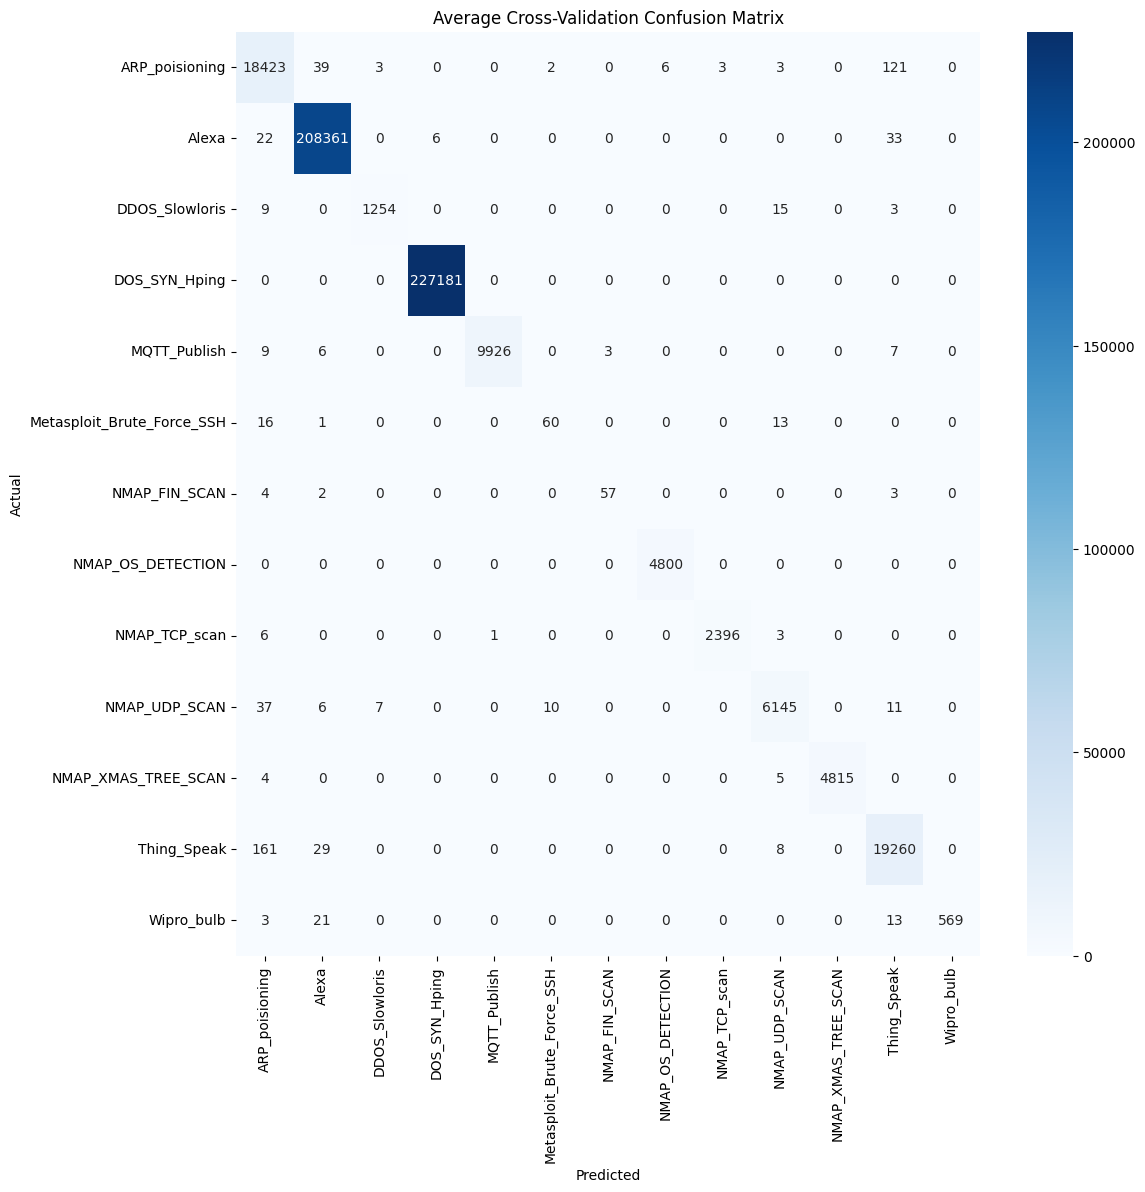

Average Confusion Matrix saved to ./checkpoints_xgb_100/average_confusion_matrix_100.png



In [30]:
# Total number of folds
total_folds = N_FOLDS * N_REPEATS

# Compute and print average cross-validation metrics
compute_and_print_average_metrics(
    n_folds=total_folds, 
    metrics_per_fold_path=CHECKPOINT_DIR, 
    class_labels=class_labels  # Correct variable name
)


Best model loaded from ./checkpoints_xgb_100/best_xgb_model_100.joblib
Before preprocessing: X_test shape: (41992, 83)
After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating the best model on the test set...


Test Balanced Accuracy: 0.9796
Test Accuracy: 0.9989
Test Macro F1 Score: 0.9703
Test Precision (Macro): 0.9685
Test Recall (Macro): 0.9796
Test ROC AUC Score: 1.0000
Test metrics saved to ./checkpoints_xgb_100/test_metrics_100.json
Test classification report saved to ./checkpoints_xgb_100/test_classification_report_100.csv


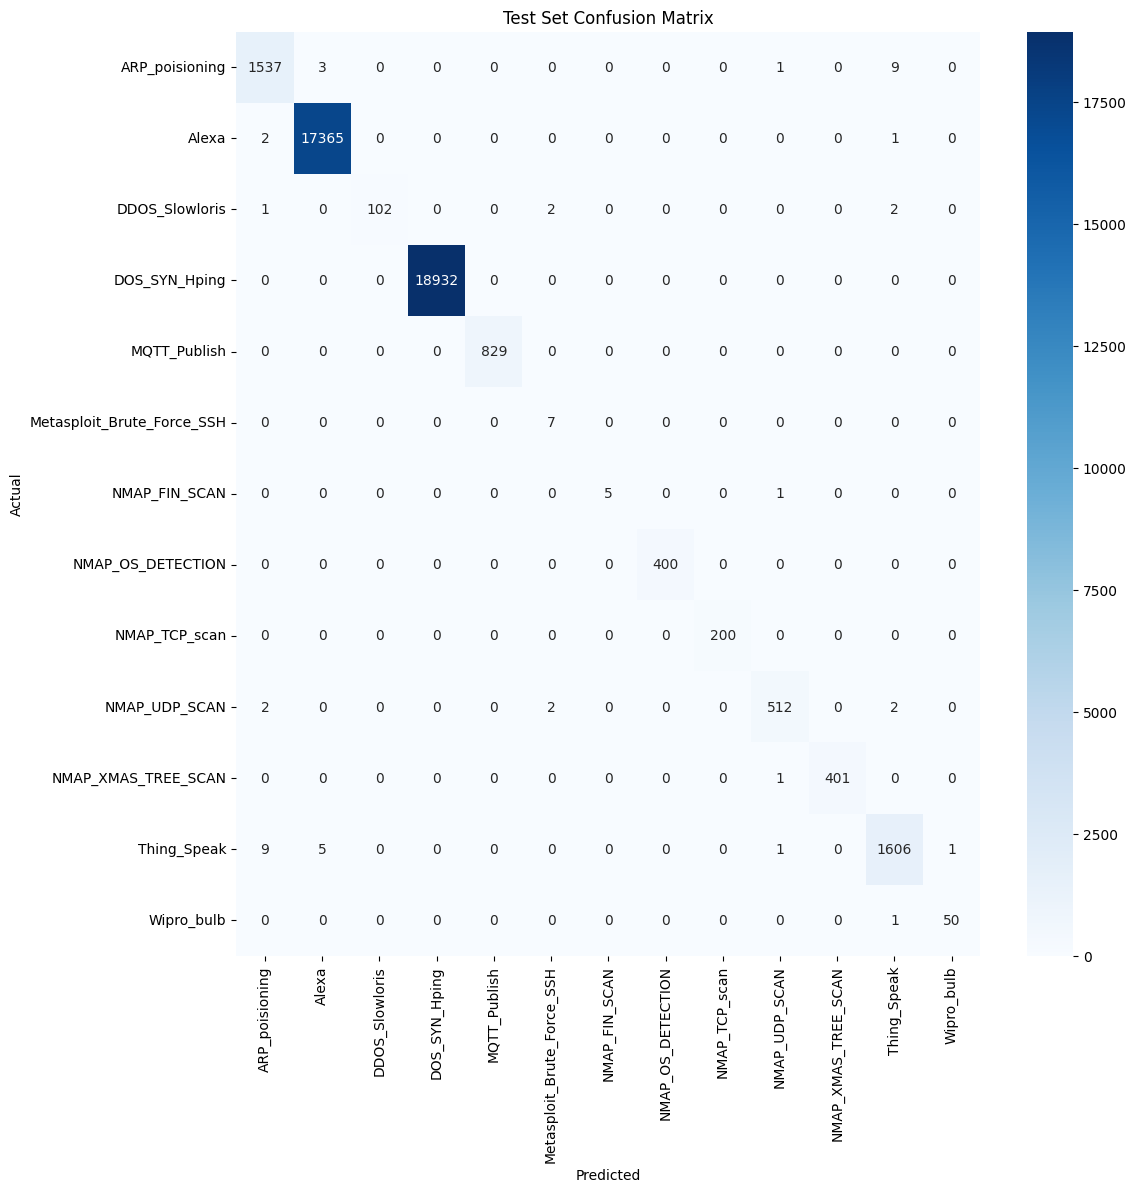

Confusion matrix saved to ./checkpoints_xgb_100/test_confusion_matrix_100.png


Generating ROC Curves...


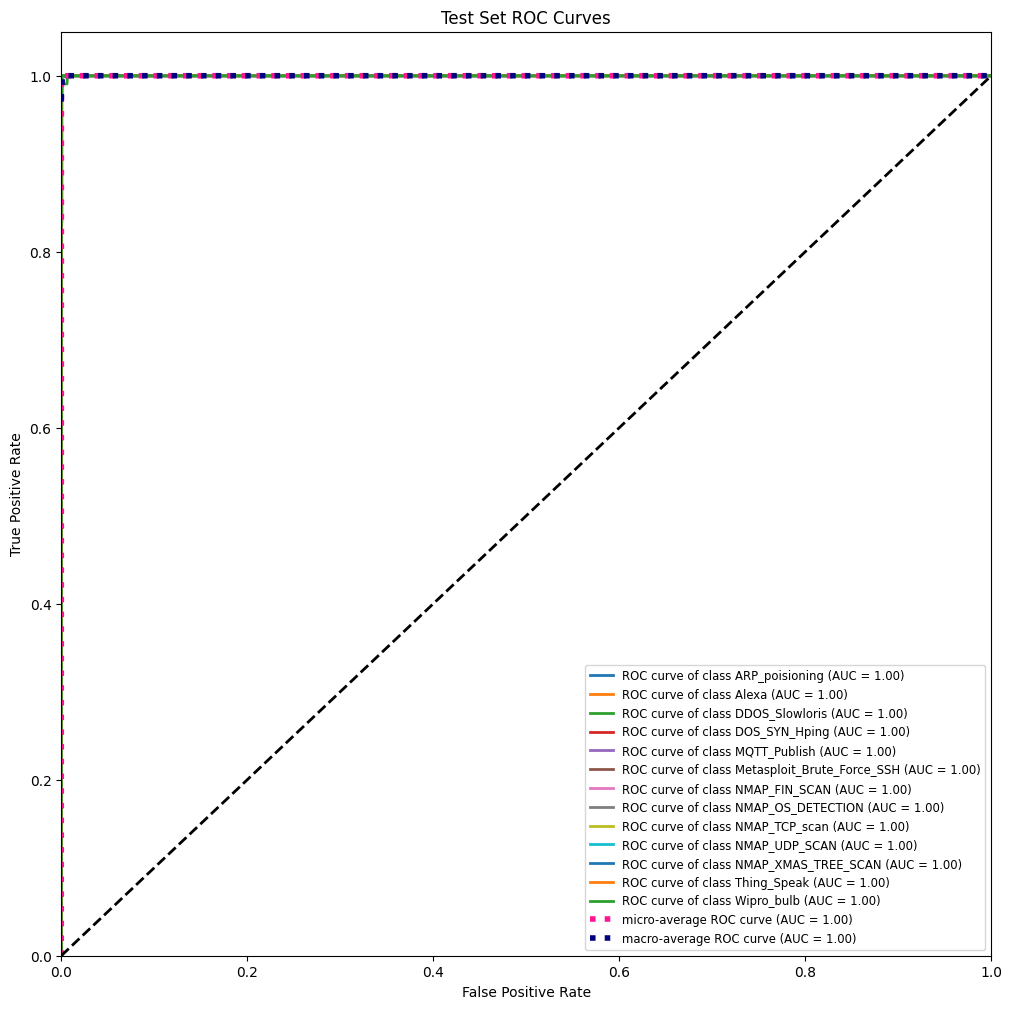

ROC Curves generated and saved to './checkpoints_xgb_100/test_roc_curves_100.png'



24558

In [31]:
# ---------------------------
# 3. Load the Best Model and Evaluate on the Test Set
# ---------------------------

# Path to the best model
best_model_path = os.path.join(CHECKPOINT_DIR, f"best_xgb_model{num_iters}.joblib")

# Check if the best model exists
if os.path.exists(best_model_path):
   # Load the best model (which includes preprocessing)
   
    best_model = joblib.load(best_model_path)
    print(f"\nBest model loaded from {best_model_path}")
else:
    print("No best model found. Please ensure that cross-validation has been run successfully.")
    best_model = model_pipeline  # Fallback to the last trained model
    
    
# Access the preprocessor from the pipeline
preprocessor = best_model.named_steps['preprocessor']

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)

# Print the shape before and after preprocessing
print(f"Before preprocessing: X_test shape: {X_test.shape}")
print(f"After preprocessing: X_test_transformed shape: {X_test_transformed.shape}")    
 

# Evaluate on the test set
print("\nEvaluating the best model on the test set...")
Y_test_pred = best_model.predict(X_test)
Y_test_pred_proba = best_model.predict_proba(X_test)

test_bal_acc = balanced_accuracy_score(Y_test, Y_test_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
test_macro_f1 = f1_score(Y_test, Y_test_pred, average='macro')
test_precision = precision_score(Y_test, Y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(Y_test, Y_test_pred, average='macro', zero_division=0)
Y_test_bin = label_binarize(Y_test, classes=np.arange(CLASSES))
test_auc = roc_auc_score(Y_test_bin, Y_test_pred_proba, average='macro', multi_class='ovo')

print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test ROC AUC Score: {test_auc:.4f}")

# Save test metrics
test_metrics = {
    "test_balanced_accuracy": test_bal_acc,
    "test_accuracy": test_accuracy,
    "test_macro_f1": test_macro_f1,
    "test_precision_macro": test_precision,
    "test_recall_macro": test_recall,
    "test_auc": test_auc,
}
test_metrics_file = os.path.join(CHECKPOINT_DIR, f"test_metrics{num_iters}.json")
with open(test_metrics_file, 'w') as f:
    json.dump(test_metrics, f, indent=4)
print(f"Test metrics saved to {test_metrics_file}")

# Generate classification report
test_classification_report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)
test_report_df = pd.DataFrame(test_classification_report).transpose()
test_report_file = os.path.join(CHECKPOINT_DIR, f"test_classification_report{num_iters}.csv")
test_report_df.to_csv(test_report_file, index=True)
print(f"Test classification report saved to {test_report_file}")

# Plot confusion matrix
cm_test = confusion_matrix(Y_test, Y_test_pred)
plt.figure(figsize=FIG_SIZE)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix')
cm_file = os.path.join(CHECKPOINT_DIR, f'test_confusion_matrix{num_iters}.png')
plt.savefig(cm_file)
plt.show()
plt.close()
print(f"Confusion matrix saved to {cm_file}\n")

# ---------------------------
# 4. Generate ROC Curves
# ---------------------------

print("\nGenerating ROC Curves...")
plot_roc_curves(
    Y_true=Y_test,
    Y_score=Y_test_pred_proba,
    class_labels=class_labels,
    fig_size=FIG_SIZE,
    save_path=CHECKPOINT_DIR
)

# Clean up to save memory
gc.collect()

In [32]:
import os
import joblib
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import label_binarize

# ---------------------------
# 3. Load All Fold Models and Evaluate on the Test Set
# ---------------------------

# List to hold metrics for each fold
all_metrics = []

# Loop through folds 1 to 30
for fold in range(1, 31):
    fold = fold + 1
    model_path = os.path.join(CHECKPOINT_DIR, f"model_fold{fold}{num_iters}.joblib")
    if os.path.exists(model_path):
        # Load the model for the current fold (which includes preprocessing)
        model = joblib.load(model_path)
        print(f"\nModel loaded from {model_path}")
        
        # Access the preprocessor from the pipeline
        preprocessor = model.named_steps['preprocessor']
        # Transform the test data
        X_test_transformed = preprocessor.transform(X_test)
        
        # Print the shape before and after preprocessing
        print(f"Fold {fold}: Before preprocessing: X_test shape: {X_test.shape}")
        print(f"Fold {fold}: After preprocessing: X_test_transformed shape: {X_test_transformed.shape}")
        
        # Evaluate on the test set
        print(f"\nEvaluating fold {fold} on the test set...")
        Y_test_pred = model.predict(X_test)
        Y_test_pred_proba = model.predict_proba(X_test)
        
        test_bal_acc = balanced_accuracy_score(Y_test, Y_test_pred)
        test_accuracy = accuracy_score(Y_test, Y_test_pred)
        test_macro_f1 = f1_score(Y_test, Y_test_pred, average='macro')
        test_precision = precision_score(Y_test, Y_test_pred, average='macro', zero_division=0)
        test_recall = recall_score(Y_test, Y_test_pred, average='macro', zero_division=0)
        
        # Convert Y_test to binary for multi-class AUC calculation
        Y_test_bin = label_binarize(Y_test, classes=np.arange(CLASSES))
        test_auc = roc_auc_score(Y_test_bin, Y_test_pred_proba, average='macro', multi_class='ovo')
        
        # Collect metrics for the current fold
        fold_metrics = {
            "fold": fold,
            "balanced_accuracy": test_bal_acc,
            "accuracy": test_accuracy,
            "macro_f1": test_macro_f1,
            "precision_macro": test_precision,
            "recall_macro": test_recall,
            "auc": test_auc,
        }
        all_metrics.append(fold_metrics)
        print(f"Fold {fold} metrics: {fold_metrics}")
    else:
        print(f"Model file not found: {model_path}")

# Convert the list of metrics dictionaries to a DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Calculate the mean and standard deviation for each metric across folds
mean_metrics = metrics_df.mean(numeric_only=True)
std_metrics = metrics_df.std(numeric_only=True)

# Print the aggregated results in "mean ± std" format
print("\nAggregated Metrics Across All Folds:")
for metric in mean_metrics.index:
    mean_val = mean_metrics[metric]
    std_val = std_metrics[metric]
    print(f"{metric}: {mean_val:.5f} ± {std_val:.5f}")

# Save detailed fold metrics and aggregated (mean and std) metrics to a JSON file
aggregated_metrics = {
    "detailed": all_metrics,
    "mean": mean_metrics.to_dict(),
    "std": std_metrics.to_dict(),
}
metrics_file = os.path.join(CHECKPOINT_DIR, f"all_folds_metrics{num_iters}.json")
with open(metrics_file, 'w') as f:
    json.dump(aggregated_metrics, f, indent=4)
print(f"\nAll folds metrics saved to {metrics_file}")

# Clean up to save memory
gc.collect()



Model loaded from ./checkpoints_xgb_100/model_fold2_100.joblib
Fold 2: Before preprocessing: X_test shape: (41992, 83)
Fold 2: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 2 on the test set...


Fold 2 metrics: {'fold': 2, 'balanced_accuracy': 0.9784713321826183, 'accuracy': 0.9988569251285959, 'macro_f1': 0.9696970072535536, 'precision_macro': 0.9684304072791853, 'recall_macro': 0.9784713321826183, 'auc': 0.9999793054276375}

Model loaded from ./checkpoints_xgb_100/model_fold3_100.joblib
Fold 3: Before preprocessing: X_test shape: (41992, 83)
Fold 3: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 3 on the test set...


Fold 3 metrics: {'fold': 3, 'balanced_accuracy': 0.9779676868453175, 'accuracy': 0.9988807391884168, 'macro_f1': 0.9691590869239604, 'precision_macro': 0.9678034651800154, 'recall_macro': 0.9779676868453175, 'auc': 0.999983573020679}

Model loaded from ./checkpoints_xgb_100/model_fold4_100.joblib
Fold 4: Before preprocessing: X_test shape: (41992, 83)
Fold 4: After preprocessing: X_test_transformed shape: (41992, 93)

Evaluating fold 4 on the test set...


Fold 4 metrics: {'fold': 4, 'balanced_accuracy': 0.978279314801196, 'accuracy': 0.9989283673080587, 'macro_f1': 0.9871804667568198, 'precision_macro': 0.997432972323024, 'recall_macro': 0.978279314801196, 'auc': 0.9999706710181856}

Model loaded from ./checkpoints_xgb_100/model_fold5_100.joblib
Fold 5: Before preprocessing: X_test shape: (41992, 83)
Fold 5: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 5 on the test set...


Fold 5 metrics: {'fold': 5, 'balanced_accuracy': 0.9792818772248499, 'accuracy': 0.998809297008954, 'macro_f1': 0.9880286904019774, 'precision_macro': 0.9980475199733706, 'recall_macro': 0.9792818772248499, 'auc': 0.99998223853561}

Model loaded from ./checkpoints_xgb_100/model_fold6_100.joblib
Fold 6: Before preprocessing: X_test shape: (41992, 83)
Fold 6: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 6 on the test set...


Fold 6 metrics: {'fold': 6, 'balanced_accuracy': 0.9780581305887583, 'accuracy': 0.9989283673080587, 'macro_f1': 0.9699330530000313, 'precision_macro': 0.9693071207564441, 'recall_macro': 0.9780581305887583, 'auc': 0.9999853768447345}

Model loaded from ./checkpoints_xgb_100/model_fold7_100.joblib
Fold 7: Before preprocessing: X_test shape: (41992, 83)
Fold 7: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 7 on the test set...


Fold 7 metrics: {'fold': 7, 'balanced_accuracy': 0.9779925859433796, 'accuracy': 0.998809297008954, 'macro_f1': 0.969315053956104, 'precision_macro': 0.9681897117238758, 'recall_macro': 0.9779925859433796, 'auc': 0.999978691363556}

Model loaded from ./checkpoints_xgb_100/model_fold8_100.joblib
Fold 8: Before preprocessing: X_test shape: (41992, 83)
Fold 8: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 8 on the test set...


Fold 8 metrics: {'fold': 8, 'balanced_accuracy': 0.9782274378657992, 'accuracy': 0.9988569251285959, 'macro_f1': 0.969480778277875, 'precision_macro': 0.9682863257404185, 'recall_macro': 0.9782274378657992, 'auc': 0.9999788397069765}

Model loaded from ./checkpoints_xgb_100/model_fold9_100.joblib
Fold 9: Before preprocessing: X_test shape: (41992, 83)
Fold 9: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 9 on the test set...


Fold 9 metrics: {'fold': 9, 'balanced_accuracy': 0.9764409613176969, 'accuracy': 0.9987854829491332, 'macro_f1': 0.9747051288419777, 'precision_macro': 0.9738593863964848, 'recall_macro': 0.9764409613176969, 'auc': 0.9999564693577265}

Model loaded from ./checkpoints_xgb_100/model_fold10_100.joblib
Fold 10: Before preprocessing: X_test shape: (41992, 83)
Fold 10: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 10 on the test set...


Fold 10 metrics: {'fold': 10, 'balanced_accuracy': 0.976911205805191, 'accuracy': 0.998809297008954, 'macro_f1': 0.9693834682195998, 'precision_macro': 0.9694237244692256, 'recall_macro': 0.976911205805191, 'auc': 0.9999824320917614}

Model loaded from ./checkpoints_xgb_100/model_fold11_100.joblib
Fold 11: Before preprocessing: X_test shape: (41992, 83)
Fold 11: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 11 on the test set...


Fold 11 metrics: {'fold': 11, 'balanced_accuracy': 0.9795770577881184, 'accuracy': 0.9989045532482378, 'macro_f1': 0.970295257005975, 'precision_macro': 0.9684817991407955, 'recall_macro': 0.9795770577881184, 'auc': 0.9999794450756205}

Model loaded from ./checkpoints_xgb_100/model_fold12_100.joblib
Fold 12: Before preprocessing: X_test shape: (41992, 83)
Fold 12: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 12 on the test set...


Fold 12 metrics: {'fold': 12, 'balanced_accuracy': 0.9782154425769443, 'accuracy': 0.9989521813678796, 'macro_f1': 0.9705328457209773, 'precision_macro': 0.9703823284680837, 'recall_macro': 0.9782154425769443, 'auc': 0.9999804216096506}

Model loaded from ./checkpoints_xgb_100/model_fold13_100.joblib
Fold 13: Before preprocessing: X_test shape: (41992, 83)
Fold 13: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 13 on the test set...


Fold 13 metrics: {'fold': 13, 'balanced_accuracy': 0.9778272320841237, 'accuracy': 0.9987616688893123, 'macro_f1': 0.9700661925824056, 'precision_macro': 0.9698348998648592, 'recall_macro': 0.9778272320841237, 'auc': 0.9999754819169061}

Model loaded from ./checkpoints_xgb_100/model_fold14_100.joblib
Fold 14: Before preprocessing: X_test shape: (41992, 83)
Fold 14: After preprocessing: X_test_transformed shape: (41992, 93)

Evaluating fold 14 on the test set...


Fold 14 metrics: {'fold': 14, 'balanced_accuracy': 0.9794717728372201, 'accuracy': 0.9988807391884168, 'macro_f1': 0.987173754167143, 'precision_macro': 0.9961291077231702, 'recall_macro': 0.9794717728372201, 'auc': 0.9999787079398216}

Model loaded from ./checkpoints_xgb_100/model_fold15_100.joblib
Fold 15: Before preprocessing: X_test shape: (41992, 83)
Fold 15: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 15 on the test set...


Fold 15 metrics: {'fold': 15, 'balanced_accuracy': 0.9774447045644963, 'accuracy': 0.9989045532482378, 'macro_f1': 0.969210286685433, 'precision_macro': 0.9684972647693961, 'recall_macro': 0.9774447045644963, 'auc': 0.9999768328377759}

Model loaded from ./checkpoints_xgb_100/model_fold16_100.joblib
Fold 16: Before preprocessing: X_test shape: (41992, 83)
Fold 16: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 16 on the test set...


Fold 16 metrics: {'fold': 16, 'balanced_accuracy': 0.9796182569661857, 'accuracy': 0.9989759954277005, 'macro_f1': 0.9710402436033558, 'precision_macro': 0.9699456202980993, 'recall_macro': 0.9796182569661857, 'auc': 0.9999816236112399}



Model loaded from ./checkpoints_xgb_100/model_fold17_100.joblib
Fold 17: Before preprocessing: X_test shape: (41992, 83)
Fold 17: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 17 on the test set...


Fold 17 metrics: {'fold': 17, 'balanced_accuracy': 0.9796222796598391, 'accuracy': 0.9989283673080587, 'macro_f1': 0.9702990316770724, 'precision_macro': 0.9684441520900228, 'recall_macro': 0.9796222796598391, 'auc': 0.9999750727061106}

Model loaded from ./checkpoints_xgb_100/model_fold18_100.joblib
Fold 18: Before preprocessing: X_test shape: (41992, 83)
Fold 18: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 18 on the test set...


Fold 18 metrics: {'fold': 18, 'balanced_accuracy': 0.9789033723988756, 'accuracy': 0.9989045532482378, 'macro_f1': 0.978071951068324, 'precision_macro': 0.9806832001489814, 'recall_macro': 0.9789033723988756, 'auc': 0.9999759830426603}

Model loaded from ./checkpoints_xgb_100/model_fold19_100.joblib
Fold 19: Before preprocessing: X_test shape: (41992, 83)
Fold 19: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 19 on the test set...


Fold 19 metrics: {'fold': 19, 'balanced_accuracy': 0.977715502101892, 'accuracy': 0.9987854829491332, 'macro_f1': 0.9691025057901524, 'precision_macro': 0.9679473244907109, 'recall_macro': 0.977715502101892, 'auc': 0.9999792573801123}

Model loaded from ./checkpoints_xgb_100/model_fold20_100.joblib
Fold 20: Before preprocessing: X_test shape: (41992, 83)
Fold 20: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 20 on the test set...


Fold 20 metrics: {'fold': 20, 'balanced_accuracy': 0.9789015526651438, 'accuracy': 0.9989521813678796, 'macro_f1': 0.986821370283234, 'precision_macro': 0.9960319202404926, 'recall_macro': 0.9789015526651438, 'auc': 0.9999794638337391}

Model loaded from ./checkpoints_xgb_100/model_fold21_100.joblib
Fold 21: Before preprocessing: X_test shape: (41992, 83)
Fold 21: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 21 on the test set...


Fold 21 metrics: {'fold': 21, 'balanced_accuracy': 0.9798226105598238, 'accuracy': 0.9989759954277005, 'macro_f1': 0.9712418918347397, 'precision_macro': 0.9701444826828409, 'recall_macro': 0.9798226105598238, 'auc': 0.9999670612426339}

Model loaded from ./checkpoints_xgb_100/model_fold22_100.joblib
Fold 22: Before preprocessing: X_test shape: (41992, 83)
Fold 22: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 22 on the test set...


Fold 22 metrics: {'fold': 22, 'balanced_accuracy': 0.9796656587058715, 'accuracy': 0.9989759954277005, 'macro_f1': 0.9705896223676089, 'precision_macro': 0.9689887814815152, 'recall_macro': 0.9796656587058715, 'auc': 0.9999816427360559}

Model loaded from ./checkpoints_xgb_100/model_fold23_100.joblib
Fold 23: Before preprocessing: X_test shape: (41992, 83)
Fold 23: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 23 on the test set...


Fold 23 metrics: {'fold': 23, 'balanced_accuracy': 0.9783764825193345, 'accuracy': 0.998809297008954, 'macro_f1': 0.97029431704669, 'precision_macro': 0.9697344907155055, 'recall_macro': 0.9783764825193345, 'auc': 0.9999766852478338}

Model loaded from ./checkpoints_xgb_100/model_fold24_100.joblib
Fold 24: Before preprocessing: X_test shape: (41992, 83)
Fold 24: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 24 on the test set...


Fold 24 metrics: {'fold': 24, 'balanced_accuracy': 0.9790004250220807, 'accuracy': 0.9989521813678796, 'macro_f1': 0.9707820392393258, 'precision_macro': 0.9700854074035642, 'recall_macro': 0.9790004250220807, 'auc': 0.9999828827475133}



Model loaded from ./checkpoints_xgb_100/model_fold25_100.joblib
Fold 25: Before preprocessing: X_test shape: (41992, 83)
Fold 25: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 25 on the test set...


Fold 25 metrics: {'fold': 25, 'balanced_accuracy': 0.9774443213383066, 'accuracy': 0.9988569251285959, 'macro_f1': 0.986303960128952, 'precision_macro': 0.9964760443419963, 'recall_macro': 0.9774443213383066, 'auc': 0.9999808289125481}

Model loaded from ./checkpoints_xgb_100/model_fold26_100.joblib
Fold 26: Before preprocessing: X_test shape: (41992, 83)
Fold 26: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 26 on the test set...


Fold 26 metrics: {'fold': 26, 'balanced_accuracy': 0.9781073520621759, 'accuracy': 0.9988807391884168, 'macro_f1': 0.9696426896505917, 'precision_macro': 0.9686643727493235, 'recall_macro': 0.9781073520621759, 'auc': 0.9999823308666822}

Model loaded from ./checkpoints_xgb_100/model_fold27_100.joblib
Fold 27: Before preprocessing: X_test shape: (41992, 83)
Fold 27: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 27 on the test set...


Fold 27 metrics: {'fold': 27, 'balanced_accuracy': 0.977427490719507, 'accuracy': 0.9988569251285959, 'macro_f1': 0.986049686694748, 'precision_macro': 0.995952097140096, 'recall_macro': 0.977427490719507, 'auc': 0.9999831358287745}

Model loaded from ./checkpoints_xgb_100/model_fold28_100.joblib
Fold 28: Before preprocessing: X_test shape: (41992, 83)
Fold 28: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 28 on the test set...


Fold 28 metrics: {'fold': 28, 'balanced_accuracy': 0.9784239073509764, 'accuracy': 0.998833111068775, 'macro_f1': 0.969577695845476, 'precision_macro': 0.9682388386431433, 'recall_macro': 0.9784239073509764, 'auc': 0.999978470334217}

Model loaded from ./checkpoints_xgb_100/model_fold29_100.joblib
Fold 29: Before preprocessing: X_test shape: (41992, 83)
Fold 29: After preprocessing: X_test_transformed shape: (41992, 93)

Evaluating fold 29 on the test set...


Fold 29 metrics: {'fold': 29, 'balanced_accuracy': 0.9770502453261452, 'accuracy': 0.9987378548294913, 'macro_f1': 0.9696850316159011, 'precision_macro': 0.9698901802270593, 'recall_macro': 0.9770502453261452, 'auc': 0.9999819576509493}

Model loaded from ./checkpoints_xgb_100/model_fold30_100.joblib
Fold 30: Before preprocessing: X_test shape: (41992, 83)
Fold 30: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 30 on the test set...


Fold 30 metrics: {'fold': 30, 'balanced_accuracy': 0.9781680408372584, 'accuracy': 0.9989521813678796, 'macro_f1': 0.977869896238754, 'precision_macro': 0.9810230601633161, 'recall_macro': 0.9781680408372584, 'auc': 0.9999731561466241}
Model file not found: ./checkpoints_xgb_100/model_fold31_100.joblib

Aggregated Metrics Across All Folds:
fold: 16.00000 ± 8.51469
balanced_accuracy: 0.97836 ± 0.00090
accuracy: 0.99888 ± 0.00007
macro_f1: 0.97419 ± 0.00699
precision_macro: 0.97574 ± 0.01134
recall_macro: 0.97836 ± 0.00090
auc: 0.99998 ± 0.00001

All folds metrics saved to ./checkpoints_xgb_100/all_folds_metrics_100.json


536